## Doing Business in Nigeria

Nigeria is one fast developing startup landscape within Africa. The startup landscape cuts across various industries including FinTech, Agrictech, Infrasturture, etc and have a proven track record of breathing multi-million dollar companies that do compete in the world stage. Recent example is the recent acquisition of Paystack by Stripe in the tone of $200 million. However, like in most African countries, the development of these thriving ecosystem are islolate to very few locations or cities. In Nigeria, Lagos stands out the goto location for business development.

In this project, I look into some factors that do effect (encourage or hinder) startup or generally business development in Nigeria. This is with the go of identifing commonallies account states or regions within the Nation. These commonalities can help indentifies development area that might help drive more startup areas or help replicate some of the successes in Lagos.

### Factors considered: 
- Ease of starting a business
- Ease of Registering property
- Dealing with construction permits
- Enforcing contracts

### Factors not considered: 
- Security
- Market size (population, wage, prices, unemployment, POS vs cash statistics, phone/internent access, cost of information)
- Macroeconomic stability
- State of the financial system
- Prevalence of bribery and corruption
- Level of training and skills of the labor force
- transportation

Data extracted from 2018 International Bank for Reconstruction and Development/The World Bank

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
#!pip install Cartopy
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn import metrics

import time
np.random.seed(0)

from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, ElasticNetCV, HuberRegressor, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, cross_val_predict

import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from mpl_toolkits.basemap import Basemap
from ipywidgets import interact
import ipywidgets as widgets


SPECTRAL_CMAP = plt.get_cmap('nipy_spectral', 12)
SPECTRAL_CMAP.set_under('black')
SPECTRAL_CMAP.set_over('grey')

import warnings
warnings.filterwarnings("ignore")

In [2]:

### Plot training history
def deviance(reg, X_test, y_test, plot=False):
    test_score = np.zeros((reg.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(X_test)):
        test_score[i] = reg.loss_(y_test, y_pred)

    if plot == True:
        fig = plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('Deviance')
        plt.plot(np.arange(reg.n_estimators) + 1, reg.train_score_, 'b-',label='Training loss')
        plt.plot(np.arange(reg.n_estimators) + 1, test_score, 'r-',label='Test loss')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('Loss')
        plt.legend(loc='upper right'); plt.grid()
    else:
        return test_score
    
### Convert features to categorical features
def convert_categorical(data,features):
    
    for name in features:
        data[name] = data[name].astype('category')
    cat_columns = data.select_dtypes(['category']).columns
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    
    return data
    
### One-hot encoding of categorical features
def cat_encode(data):
    
    for feature, values in CATEGORICAL_FEATURES.items():
        print(feature, values)
        unknown_cat = set(data[feature]).difference(values)
        assert not unknown_cat, 'categorical feature %s has unexpected value(s):\n%s'.format(feature, ', '.join(str(x) for x in unknown_cat))
        dtype = pd.api.types.CategoricalDtype(categories=values)
        data[feature] = data[feature].astype(dtype)
    
    return pd.get_dummies(data, columns=CATEGORICAL_FEATURES.keys(), prefix_sep='~')

In [3]:
df_DTFScore = pd.read_csv('DTF Score-Table 1.csv').dropna(axis=1,how='all')
print(df_DTFScore.shape)
df_DTFScore = df_DTFScore.drop(columns=['Trend','Starting a business (Rank)', 'Dealing with\nconstruction permits (Rank)','Registering property (Rank)','Enforcing contracts (Rank)'])
df_DTFScore.head()

(37, 12)


,State,"DTF score,\n2018\n(4 indicators)","Average\nDTF score,\n2014\n(4 indicators)",Starting a business (Score),Dealing with\nconstruction permits (Score),Registering property (Score),Enforcing contracts (Score)
0,Abia,53.90,48.24,77.10,72.72,17.67,48.11
1,Adamawa,54.34,52.83,71.96,73.63,23.93,47.84
2,Akwa Ibom,55.66,53.41,76.17,71.31,21.46,53.70
3,Anambra,53.50,48.60,76.69,70.18,19.33,47.80
4,Bauchi,60.60,56.85,76.06,74.10,28.26,63.99


Loading data on some information on the easy of developing or enforcing business contracts per state.

In [4]:
df_contractEnforce = pd.read_csv('Enforcing contracts-Table 1.csv').dropna(axis=1,how='all')
print(df_contractEnforce.shape)
df_contractEnforce = df_contractEnforce.drop(columns=['Rank'])
df_contractEnforce.head()

(37, 6)


,State,Distance to frontier score (0–100),Enforcing Time (days),Enforcing Cost (% of claim value),Quality of judicial processes index (0–18)
0,Kaduna,65.10,307,25.2,7.0
1,Bauchi,63.99,455,17.4,7.0
2,Jigawa,63.14,261,33.8,7.0
3,Borno,62.97,371,26.2,7.0
4,Katsina,62.94,375,26.0,7.0


Loading data on the easy of starting a new business with Nigeria per start. Data contain information such as Business start cost, length of time for business start, etc.

In [5]:
df_StartBuz = pd.read_csv('Starting business-Table 1.csv').dropna(axis=1,how='all')
print(df_StartBuz.shape)
df_StartBuz = df_StartBuz.drop(columns=['Rank'])
df_StartBuz.head()

(37, 6)


,State,Distance tofrontier score (0–100),Procedures (Bussines start),Time (days - Bussines start),Bussines start Cost (% of income per capita)
0,FCT Abuja,85.61,7,10,25.4
1,Lagos,83.67,8,10,29.2
2,Enugu,81.70,9,11,31.2
3,Ogun,81.69,8,18,29.0
4,Kaduna,81.43,9,13,29.3


Here, data on registering a business property.

In [6]:
df_Regprop = pd.read_csv('Registering property-Table 1.csv').dropna(axis=1,how='all')
print(df_Regprop.shape)
df_Regprop = df_Regprop.drop(columns=['Rank'])
df_Regprop.head()

(37, 7)


,State,Distance to frontier score (0–100),Procedures (Registering),Registering Time (days),Registering Cost (% of property value),Quality of land administration index (0–30)
0,Kaduna,45.72,8.0,44.0,9.5,7.5
1,Zamfara,37.39,11.0,33.0,10.0,4.5
2,Jigawa,36.79,12.0,24.0,10.5,6.0
3,FCT Abuja,36.45,12.0,53.0,12.1,13.0
4,Katsina,34.10,10.0,32.0,12.6,3.0


Here, data on complexity of quality control within each state.

In [7]:
df_QualContl = pd.read_csv('building quality control-Table 1.csv').dropna(axis=1,how='all')
print(df_QualContl.shape)
df_QualContl.head()

(37, 8)


,State,Building quality control index (0–15),Quality of building regulations (0–2),Quality control before construction (0–1),Quality control during construction (0–3),Quality control after construction (0–3),Liability and insurance regimes (0–2),Professional certifications (0–4)
0,Lagos,12.0,2.0,1,2,3,0,4
1,Kano,11.0,2.0,1,2,2,0,4
2,Niger,10.5,0.5,1,2,3,0,4
3,Ogun,10.0,1.0,1,1,3,0,4
4,Abia,9.5,1.5,1,1,2,0,4


# Data Exploration and Reduction

Let combine the each of the data sets and explore the properties. Also in the following, prepare the data for developing a cluster-based maodel for the data  

In [8]:
from functools import reduce
## Merge tables

df = reduce(lambda x,y: pd.merge(x,y, on='State', how='outer'), [df_contractEnforce, df_StartBuz, df_Regprop, df_QualContl])
df.head()
#df = pd.merge([df_contractEnforce, df_StartBuz, df_Regprop, df_QualContl], on='State')

,State,Distance to frontier score (0–100)_x,Enforcing Time (days),Enforcing Cost (% of claim value),Quality of judicial processes index (0–18),Distance tofrontier score (0–100),Procedures (Bussines start),Time (days - Bussines start),Bussines start Cost (% of income per capita),Distance to frontier score (0–100)_y,...,Registering Time (days),Registering Cost (% of property value),Quality of land administration index (0–30),Building quality control index (0–15),Quality of building regulations (0–2),Quality control before construction (0–1),Quality control during construction (0–3),Quality control after construction (0–3),Liability and insurance regimes (0–2),Professional certifications (0–4)
0,Kaduna,65.10,307,25.2,7.0,81.43,9,13,29.3,45.72,...,44.0,9.5,7.5,8.5,0.5,1,1,2,0,4
1,Bauchi,63.99,455,17.4,7.0,76.06,10,30,26.4,28.26,...,33.0,15.6,3.5,9.5,1.5,1,1,2,0,4
2,Jigawa,63.14,261,33.8,7.0,78.43,9,24,31.2,36.79,...,24.0,10.5,6.0,9.5,0.5,1,1,3,0,4
3,Borno,62.97,371,26.2,7.0,77.66,9,28,29.3,29.73,...,55.0,13.0,4.5,9.5,1.5,1,1,2,0,4
4,Katsina,62.94,375,26.0,7.0,80.14,8,24,29.3,34.10,...,32.0,12.6,3.0,8.0,0.0,1,1,2,0,4


In [9]:
print(df.columns)

Index(['State', 'Distance to frontier score (0–100)_x',
       'Enforcing Time (days)', 'Enforcing Cost (% of claim value)',
       'Quality of judicial processes index (0–18)',
       'Distance tofrontier score (0–100)', 'Procedures (Bussines start)',
       'Time (days - Bussines start)',
       'Bussines start Cost (% of income per capita)',
       'Distance to frontier score (0–100)_y', 'Procedures (Registering)',
       'Registering Time (days)', 'Registering Cost (% of property value)',
       'Quality of land administration index (0–30)',
       'Building quality control index (0–15)',
       'Quality of building regulations (0–2)',
       'Quality control before construction (0–1)',
       'Quality control during construction (0–3)',
       'Quality control after construction (0–3)',
       'Liability and insurance regimes (0–2)',
       'Professional certifications (0–4)'],
      dtype='object')


In [10]:
df.describe()

,Distance to frontier score (0–100)_x,Enforcing Time (days),Enforcing Cost (% of claim value),Quality of judicial processes index (0–18),Distance tofrontier score (0–100),Procedures (Bussines start),Time (days - Bussines start),Bussines start Cost (% of income per capita),Distance to frontier score (0–100)_y,Procedures (Registering),Registering Time (days),Registering Cost (% of property value),Quality of land administration index (0–30),Building quality control index (0–15),Quality of building regulations (0–2),Quality control before construction (0–1),Quality control during construction (0–3),Quality control after construction (0–3),Liability and insurance regimes (0–2),Professional certifications (0–4)
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,36.000000,36.000000,36.000000,36.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,37.000000
mean,55.511081,474.783784,36.962162,6.675676,76.978108,9.891892,25.648649,29.016216,26.040541,11.555556,73.458333,15.269444,5.305556,8.364865,0.554054,0.918919,1.054054,2.000000,0.0,3.837838
std,5.749561,118.337356,9.487956,0.668915,3.154453,1.100096,8.080210,3.428922,7.992649,1.252299,38.074996,4.601355,1.913403,1.601426,0.643167,0.276725,0.404554,0.707107,0.0,0.553449
min,43.250000,261.000000,17.400000,5.500000,71.040000,7.000000,10.000000,23.800000,0.000000,8.000000,24.000000,9.500000,3.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000
25%,51.290000,393.000000,28.700000,6.000000,75.210000,9.000000,22.000000,27.300000,21.210000,11.000000,46.250000,11.950000,4.000000,8.000000,0.000000,1.000000,1.000000,2.000000,0.0,4.000000
50%,56.160000,464.000000,36.500000,7.000000,76.690000,10.000000,26.000000,29.000000,25.620000,12.000000,65.000000,14.100000,5.000000,8.500000,0.500000,1.000000,1.000000,2.000000,0.0,4.000000
75%,60.200000,506.000000,42.600000,7.000000,78.350000,11.000000,30.000000,29.300000,31.230000,12.000000,98.500000,18.450000,6.125000,9.500000,1.000000,1.000000,1.000000,2.000000,0.0,4.000000
max,65.100000,774.000000,57.200000,8.000000,85.610000,12.000000,45.000000,44.200000,45.720000,15.000000,196.000000,25.600000,13.000000,12.000000,2.000000,1.000000,2.000000,3.000000,0.0,4.000000


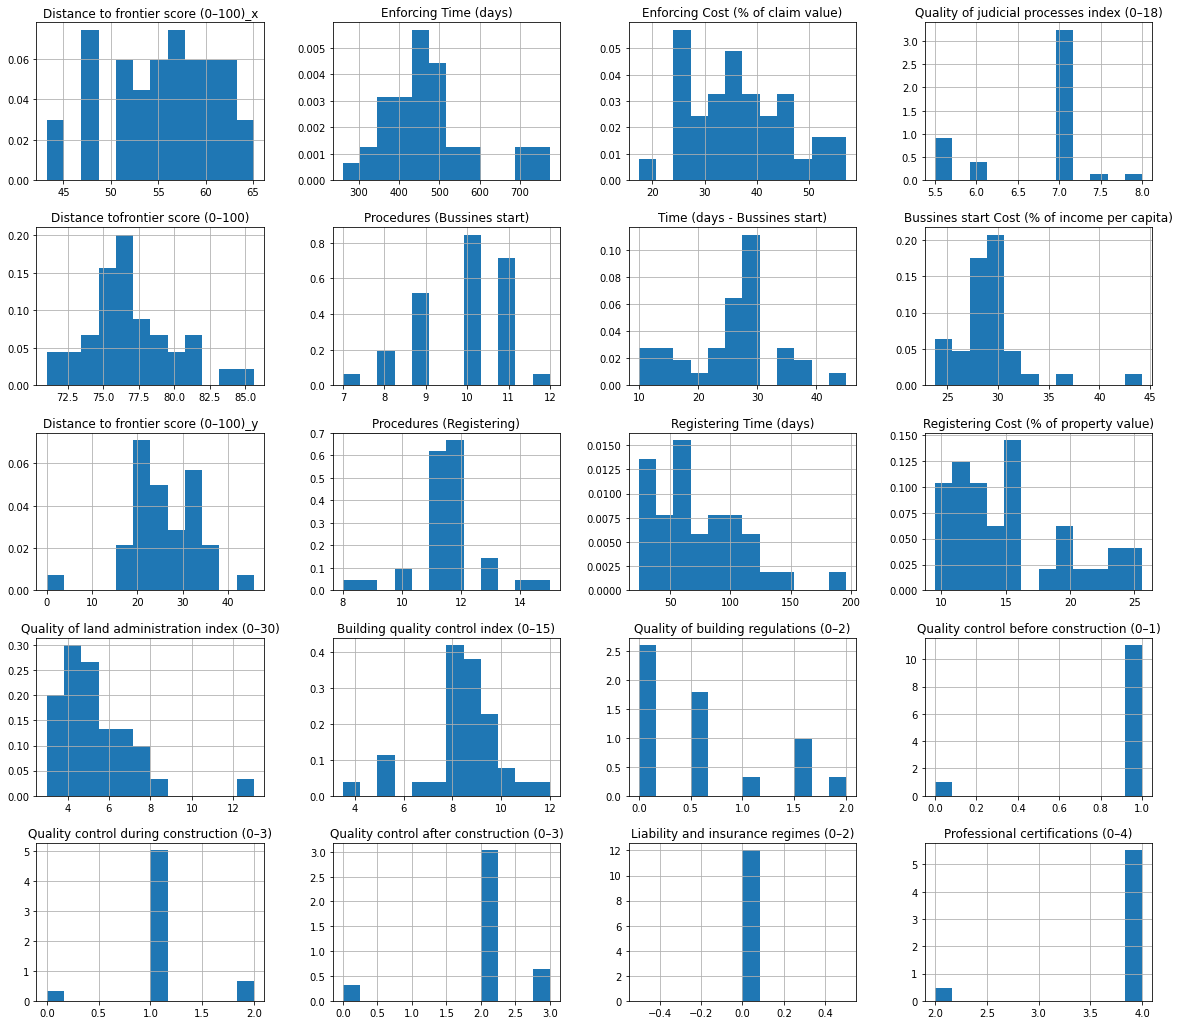

In [11]:
# Display the histogram of each column and identify feature that might be categorized.
fig, ax = plt.subplots(5, 4, figsize=(20, 18))

m=1
for i in range(5):
    for j in range(4):

        df.hist(column = df.columns[m], bins = 12, ax=ax[i,j], density=True)

        m+=1

In [12]:
df1 = convert_categorical(df,['Quality of building regulations (0–2)','Quality control before construction (0–1)', 'Quality control during construction (0–3)', 'Quality control after construction (0–3)','Liability and insurance regimes (0–2)'])

print(np.sort(df1['Quality of judicial processes index (0–18)'].unique()))

[5.5 6.  7.  7.5 8. ]


In [13]:
n = df1.nunique(axis=0)
print(n)

State                                           37
Distance to frontier score (0–100)_x            37
Enforcing Time (days)                           32
Enforcing Cost (% of claim value)               36
Quality of judicial processes index (0–18)       5
Distance tofrontier score (0–100)               37
Procedures (Bussines start)                      6
Time (days - Bussines start)                    18
Bussines start Cost (% of income per capita)    25
Distance to frontier score (0–100)_y            37
Procedures (Registering)                         8
Registering Time (days)                         29
Registering Cost (% of property value)          32
Quality of land administration index (0–30)     12
Building quality control index (0–15)           13
Quality of building regulations (0–2)            5
Quality control before construction (0–1)        2
Quality control during construction (0–3)        3
Quality control after construction (0–3)         3
Liability and insurance regimes

In [14]:
CATEGORICAL_FEATURES = {'Quality of building regulations (0–2)': range(5),
                        'Quality control before construction (0–1)': range(2),
                        'Quality control during construction (0–3)': range(3),
                        'Quality control after construction (0–3)': range(3),
                        'Liability and insurance regimes (0–2)': range(1)}

dff = cat_encode(df1)

Quality of building regulations (0–2) range(0, 5)
Quality control before construction (0–1) range(0, 2)
Quality control during construction (0–3) range(0, 3)
Quality control after construction (0–3) range(0, 3)
Liability and insurance regimes (0–2) range(0, 1)


In [15]:
FLAGS = ['Distance tofrontier score (0–100)','Distance to frontier score (0–100)_x','Distance to frontier score (0–100)_y']

In [16]:
print(dff.shape)
dff = dff.drop(FLAGS,axis=1)
dff = dff.set_index('State')
dff.head()

(37, 30)


,Enforcing Time (days),Enforcing Cost (% of claim value),Quality of judicial processes index (0–18),Procedures (Bussines start),Time (days - Bussines start),Bussines start Cost (% of income per capita),Procedures (Registering),Registering Time (days),Registering Cost (% of property value),Quality of land administration index (0–30),...,Quality of building regulations (0–2)~4,Quality control before construction (0–1)~0,Quality control before construction (0–1)~1,Quality control during construction (0–3)~0,Quality control during construction (0–3)~1,Quality control during construction (0–3)~2,Quality control after construction (0–3)~0,Quality control after construction (0–3)~1,Quality control after construction (0–3)~2,Liability and insurance regimes (0–2)~0
State,,,,,,,,,,,,,,,,,,,,,
Kaduna,307,25.2,7.0,9,13,29.3,8.0,44.0,9.5,7.5,...,0,0,1,0,1,0,0,1,0,1
Bauchi,455,17.4,7.0,10,30,26.4,11.0,33.0,15.6,3.5,...,0,0,1,0,1,0,0,1,0,1
Jigawa,261,33.8,7.0,9,24,31.2,12.0,24.0,10.5,6.0,...,0,0,1,0,1,0,0,0,1,1
Borno,371,26.2,7.0,9,28,29.3,11.0,55.0,13.0,4.5,...,0,0,1,0,1,0,0,1,0,1
Katsina,375,26.0,7.0,8,24,29.3,10.0,32.0,12.6,3.0,...,0,0,1,0,1,0,0,1,0,1


In [17]:
def dnorm(df):
    df_out = df
    temp = df.filter(regex='~')
    dum_col = temp.columns.tolist()
    X_undum = df.drop(dum_col, axis = 1)
    col_stand = X_undum.columns
    
    temp_use = df[col_stand]
    scaler = StandardScaler().fit(temp_use.values) ## Normalizer gave best score with default parameters
    temp_use = scaler.transform(temp_use.values)
    df_out[col_stand] = temp_use
    
    return df_out, scaler.mean_, scaler.var_

dff = dff.fillna(0)
dff_scal, scal_mean, scal_var = dnorm(dff)

In [18]:
print(scal_mean)
print(scal_var)
dff_scal.head()

[474.78378378  36.96216216   6.67567568   9.89189189  25.64864865
  29.01621622  11.24324324  71.47297297  14.85675676   5.16216216
   8.36486486   3.83783784]
[1.36252505e+04 8.75882980e+01 4.35354273e-01 1.17750183e+00
 6.35252009e+01 1.14397370e+01 4.99488678e+00 1.51324251e+03
 2.61592111e+01 4.20343316e+00 2.49525201e+00 2.98027757e-01]


,Enforcing Time (days),Enforcing Cost (% of claim value),Quality of judicial processes index (0–18),Procedures (Bussines start),Time (days - Bussines start),Bussines start Cost (% of income per capita),Procedures (Registering),Registering Time (days),Registering Cost (% of property value),Quality of land administration index (0–30),...,Quality of building regulations (0–2)~4,Quality control before construction (0–1)~0,Quality control before construction (0–1)~1,Quality control during construction (0–3)~0,Quality control during construction (0–3)~1,Quality control during construction (0–3)~2,Quality control after construction (0–3)~0,Quality control after construction (0–3)~1,Quality control after construction (0–3)~2,Liability and insurance regimes (0–2)~0
State,,,,,,,,,,,,,,,,,,,,,
Kaduna,-1.437400,-1.256794,0.491539,-0.821924,-1.586979,0.083903,-1.451165,-0.706239,-1.047345,1.140282,...,0,0,1,0,1,0,0,1,0,1
Bauchi,-0.169487,-2.090229,0.491539,0.099627,0.545948,-0.773509,-0.108837,-0.989012,0.145318,-0.810721,...,0,0,1,0,1,0,0,1,0,1
Jigawa,-1.831481,-0.337879,0.491539,-0.821924,-0.206850,0.645657,0.338605,-1.220372,-0.851826,0.408656,...,0,0,1,0,1,0,0,0,1,1
Borno,-0.889114,-1.149943,0.491539,-0.821924,0.295015,0.083903,-0.108837,-0.423465,-0.363030,-0.322970,...,0,0,1,0,1,0,0,1,0,1
Katsina,-0.854846,-1.171314,0.491539,-1.743474,-0.206850,0.083903,-0.556280,-1.014718,-0.441238,-1.054596,...,0,0,1,0,1,0,0,1,0,1


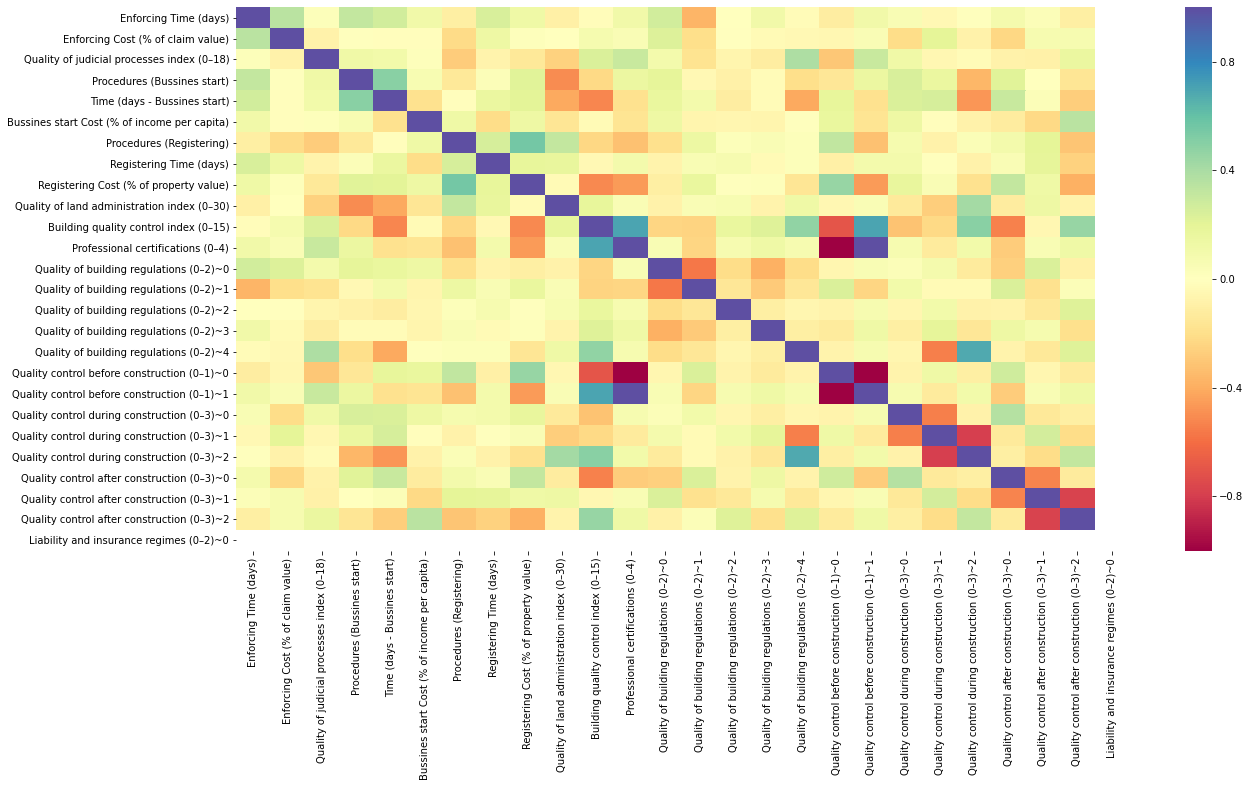

In [19]:
def get_dfcorr_map(df, colmap):
    
    # calculate the correlation matrix - Public
    corr = df.corr()

    # plot the heatmap
    plt.figure(figsize=(20,10))
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, vmin=-1.0, vmax=1.0, center= 0, annot = False, cmap=colmap)

get_dfcorr_map(dff, 'Spectral')    

Good, only few of the features show strong correlation among each other. These are related to the encoded features. PCA will be applied to the data to generate uncorrelated features for model building.

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dff)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-2.032690,-1.353312
1,-0.363420,0.520052
2,-1.403493,-1.165471
3,-0.876424,-0.298271
4,-0.822574,-0.272426


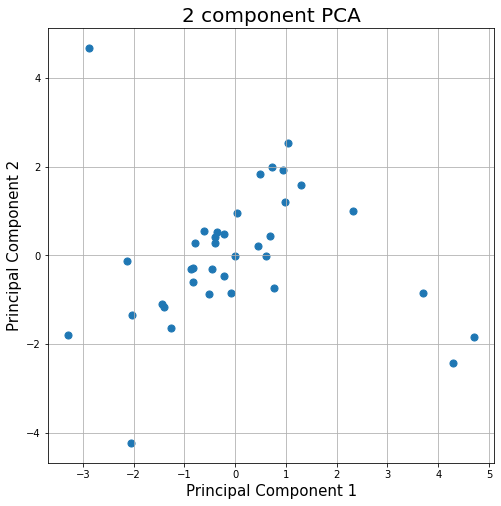

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=50)
ax.grid()

In [23]:
pca30 = PCA(n_components=26)
principalComponents30 = pca30.fit_transform(dff)
pca30.explained_variance_ratio_

array([2.16400113e-01, 1.75661011e-01, 1.22034762e-01, 9.60760025e-02,
       8.36707620e-02, 5.62604751e-02, 4.68988264e-02, 4.30823855e-02,
       3.37271028e-02, 2.98698865e-02, 2.60005820e-02, 1.78981174e-02,
       1.53403766e-02, 1.15248227e-02, 1.08971475e-02, 8.18747999e-03,
       4.08070048e-03, 1.90757395e-03, 4.81872078e-04, 1.14067121e-33,
       7.87771411e-34, 7.87771411e-34, 7.87771411e-34, 7.87771411e-34,
       7.87771411e-34, 7.87771411e-34])

(Text(0, 0.5, 'pca values'), Text(0.5, 1.0, 'PCA'))

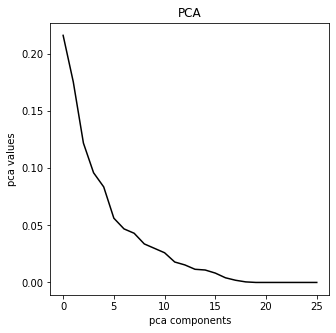

In [24]:
plt.figure(figsize=(5,5))
plt.plot(pca30.explained_variance_ratio_,'-k')
plt.xlabel('pca components');plt.ylabel('pca values'),plt.title('PCA')

(Text(0, 0.5, 'pca values'), Text(0.5, 1.0, 'PCA'))

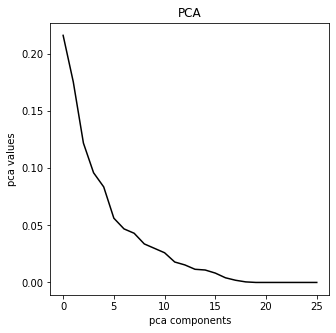

In [26]:
pca30_scal = PCA(n_components=26)
principalComponents30_scal = pca30_scal.fit_transform(dff_scal)
pca30_scal.explained_variance_ratio_

plt.figure(figsize=(5,5))
plt.plot(pca30_scal.explained_variance_ratio_,'-k')
plt.xlabel('pca components');plt.ylabel('pca values'),plt.title('PCA')

In [27]:
print(pca30_scal.explained_variance_ratio_ - pca30.explained_variance_ratio_)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [28]:
# CV of the number of components
n_samples, n_features, rank = 37, 18, 10
n_features = 18
n_components = np.arange(0, n_features, 1)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        print(n, np.mean(cross_val_score(pca, X)), np.mean(cross_val_score(fa, X)))
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))
        
    return pca_scores, fa_scores

In [29]:
pca_s, fa_s = compute_scores(dff_scal.values)

0 -29.96815685732106 -78571428574.35979
1 -30.319166548642603 -78571428554.09062
2 -30.450538825269803 -91071428546.43188
3 -31.905785264850813 -91071428544.28238
4 -32.37597809581793 -91071428535.28165
5 -32.33794693157596 -91071428533.186
6 -34.626646099981464 -91071428543.0184
7 -36.97849597660704 -91071428541.80179
8 -39.51373055320959 -114501917213.28975
9 -44.35296530395759 -114501917210.27368
10 -46.317368562300224 -114501917207.29842
11 -50.62936319669153 -114501917210.37991
12 -56.69490936378927 -114501917210.45589
13 -61.83293585881836 -114501917215.05655
14 -80.7876815126224 -114501917215.66428
15 -97.4307362735566 -114501917218.40828
16 -200.89612261770247 -114501917219.1042
17 -inf -114501917219.13428


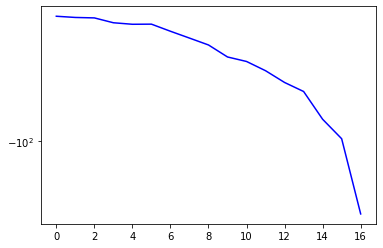

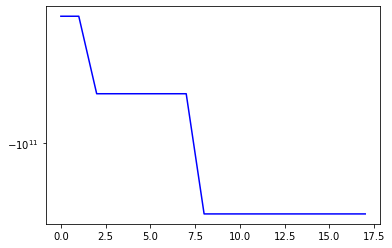

In [30]:
plt.figure()
plt.plot(n_components, pca_s, 'b', label='PCA scores')
plt.yscale('symlog')
plt.figure()
plt.plot(n_components, fa_s, 'b', label='FA scores')
plt.yscale('symlog')

In [31]:
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(dff_scal)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['p1', 'p2','p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9'])
principalDf.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,-2.032690,-1.353312,-1.634595,-0.721202,0.311410,0.071039,-0.367809,0.067294,-0.611198
1,-0.363420,0.520052,-1.322041,-1.517799,-0.900436,-0.464648,-0.238148,-0.784859,1.162390
2,-1.403493,-1.165471,-1.874937,-0.176746,-0.266768,0.215643,0.416480,0.336512,-0.521599
3,-0.876424,-0.298271,-1.100751,-0.861780,-0.538078,0.124974,-0.074737,0.167716,0.380693
4,-0.822574,-0.272426,-1.907488,-0.475517,0.232242,0.588317,-0.400547,0.116438,-0.006215


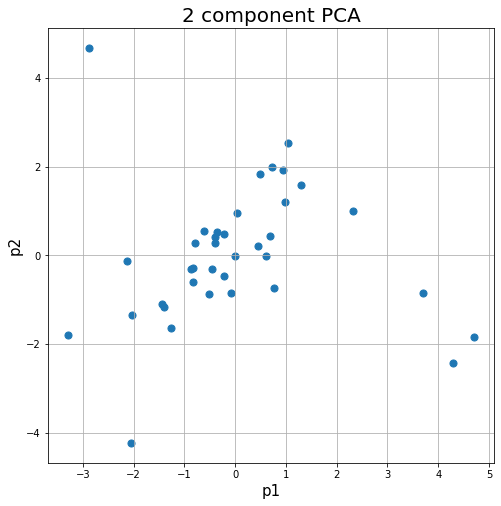

In [32]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('p1', fontsize = 15)
ax.set_ylabel('p2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['p1'], principalDf['p2'], s=50)
ax.grid()

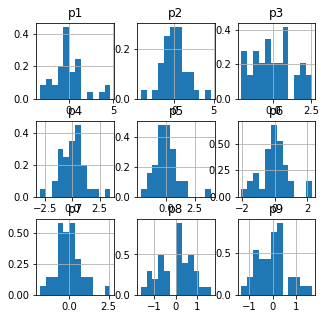

In [33]:
fig, ax = plt.subplots(3, 3, figsize=(5, 5))

m=0
for i in range(3):
    for j in range(3):

        principalDf.hist(column = principalDf.columns[m], bins = 12, ax=ax[i,j], density=True)

        m+=1

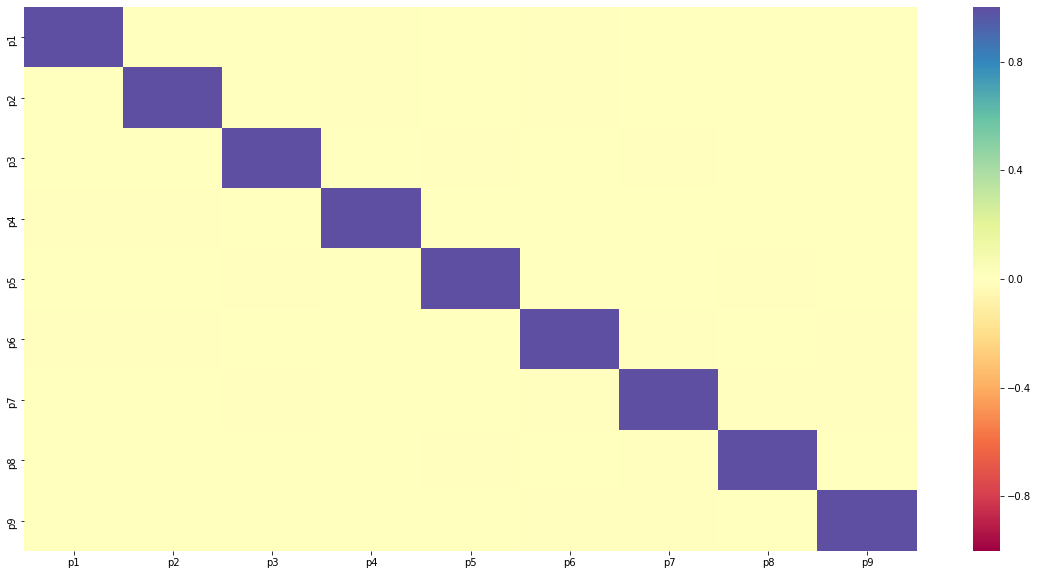

In [34]:
get_dfcorr_map(principalDf, 'Spectral')   

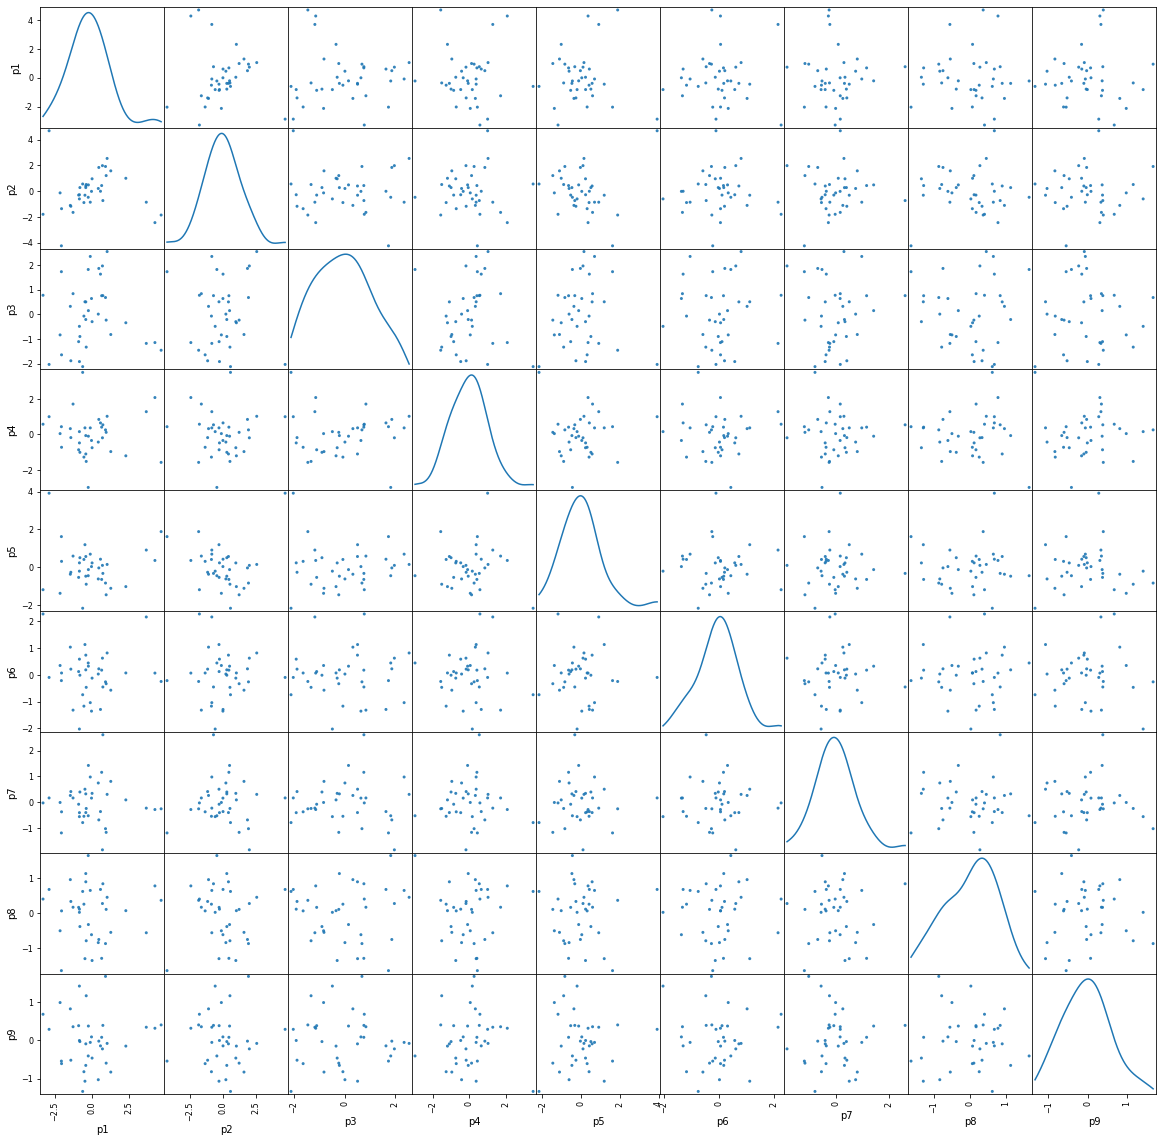

In [35]:
from pandas.plotting import scatter_matrix
scatter_matrix(principalDf, alpha=0.9, figsize=(20, 20), diagonal="kde");

In [36]:
# #############################################################################
# Compute clustering with Means
batch_size=15
n_clusters = 4
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
t0 = time.time()
k_means.fit(dff_scal)
t_batch = time.time() - t0

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(dff_scal)
t_mini_batch = time.time() - t0



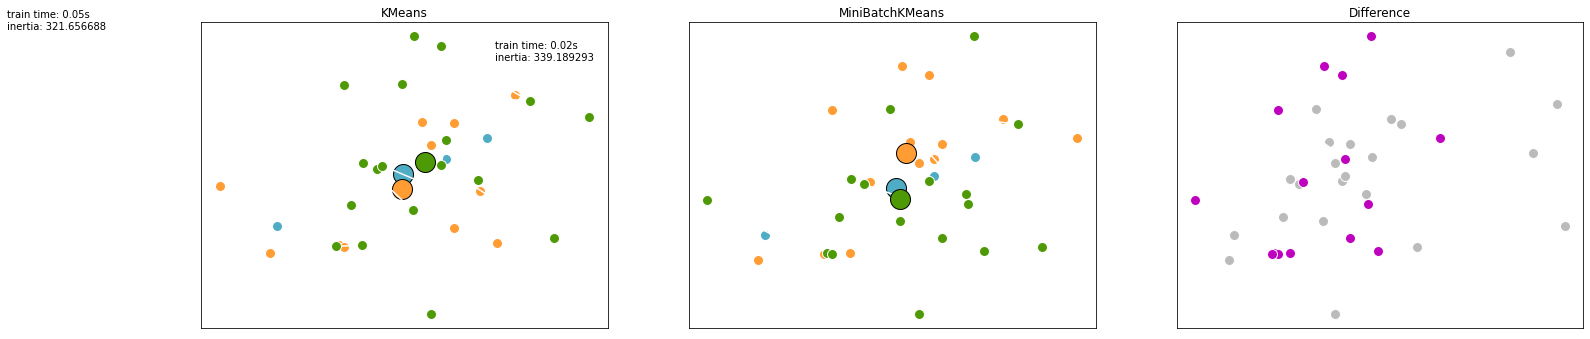

In [37]:
# #############################################################################
# Plot result
X = dff_scal.values
fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']
# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_,
                                  mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.', markersize=20)
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=20)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.', markersize=20)
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=20)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))


# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.', markersize=20)
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.', markersize=20)
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

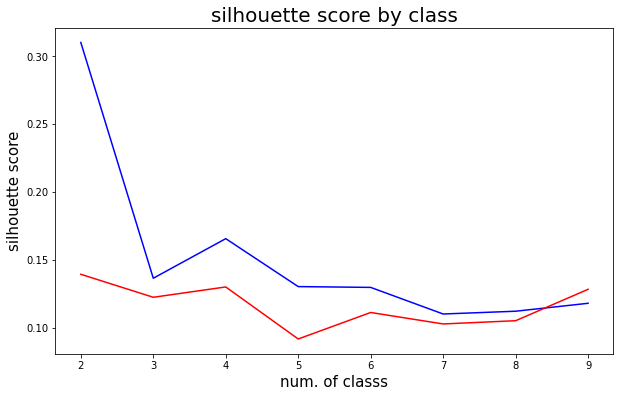

In [38]:
batch_size=15
n_clusters = 4
def get_cluster(X, n_clusters):
    # #############################################################################
    # Compute clustering with Means
    k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    t0 = time.time()
    k_means.fit(X)
    k_means_class=k_means.predict(X)
    t_batch = time.time() - t0
    
    labels = k_means.labels_
    score_kmean = metrics.silhouette_score(X, labels, metric='euclidean')

    # #############################################################################
    # Compute clustering with MiniBatchKMeans

    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(X)
    k_mbk_class=mbk.predict(X)
    t_mini_batch = time.time() - t0
    
    labels = mbk.labels_
    score_mini_kmean = metrics.silhouette_score(X, labels, metric='euclidean')
    
    return score_kmean, score_mini_kmean, k_means_class, k_mbk_class

kmean_scores, mini_kmean_scores, n_class = [], [], []
for i in range(2,10):
    #print(i)
    scr_kmean, scr_mini_kmean, k_means_class, k_mbk_class = get_cluster(dff_scal, i)
    
    kmean_scores.append(scr_kmean)
    mini_kmean_scores.append(scr_mini_kmean)
    n_class.append(i)
    
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1) 
ax.plot(n_class, kmean_scores, 'b')
ax.plot(n_class, mini_kmean_scores, 'r')
ax.set_xlabel('num. of classs', fontsize = 15)
ax.set_ylabel('silhouette score', fontsize = 15)
ax.set_title('silhouette score by class', fontsize = 20)
plt.show()

In [39]:
scr_kmean, scr_mini_kmean, k_means_class, k_mbk_class = get_cluster(dff_scal, 3)
dff['Kmean_class'] = pd.Series(k_means_class, index=dff.index)
dff['Kmean_mini_class'] = pd.Series(k_mbk_class, index=dff.index)
dff.head()

,Enforcing Time (days),Enforcing Cost (% of claim value),Quality of judicial processes index (0–18),Procedures (Bussines start),Time (days - Bussines start),Bussines start Cost (% of income per capita),Procedures (Registering),Registering Time (days),Registering Cost (% of property value),Quality of land administration index (0–30),...,Quality control before construction (0–1)~1,Quality control during construction (0–3)~0,Quality control during construction (0–3)~1,Quality control during construction (0–3)~2,Quality control after construction (0–3)~0,Quality control after construction (0–3)~1,Quality control after construction (0–3)~2,Liability and insurance regimes (0–2)~0,Kmean_class,Kmean_mini_class
State,,,,,,,,,,,,,,,,,,,,,
Kaduna,-1.437400,-1.256794,0.491539,-0.821924,-1.586979,0.083903,-1.451165,-0.706239,-1.047345,1.140282,...,1,0,1,0,0,1,0,1,2,0
Bauchi,-0.169487,-2.090229,0.491539,0.099627,0.545948,-0.773509,-0.108837,-0.989012,0.145318,-0.810721,...,1,0,1,0,0,1,0,1,0,0
Jigawa,-1.831481,-0.337879,0.491539,-0.821924,-0.206850,0.645657,0.338605,-1.220372,-0.851826,0.408656,...,1,0,1,0,0,0,1,1,2,0
Borno,-0.889114,-1.149943,0.491539,-0.821924,0.295015,0.083903,-0.108837,-0.423465,-0.363030,-0.322970,...,1,0,1,0,0,1,0,1,2,0
Katsina,-0.854846,-1.171314,0.491539,-1.743474,-0.206850,0.083903,-0.556280,-1.014718,-0.441238,-1.054596,...,1,0,1,0,0,1,0,1,2,0


In [40]:
print(dff['Kmean_class'].unique())
print(dff['Kmean_mini_class'].unique())

[2 0 1]
[0 1 2]


In [41]:
print(dff.index[dff['Kmean_class'] == 0])
print(dff.index[dff['Kmean_class'] == 1])
print(dff.index[dff['Kmean_class'] == 2])

Index(['Bauchi', 'Kebbi', 'Yobe', 'Ondo', 'Osun', 'Bayelsa', 'Zamfara',
       'Nasarawa', 'Sokoto', 'Gombe', 'Kogi', 'Benue', 'Plateau', 'Akwa Ibom',
       'Rivers', 'Ekiti', 'Taraba', 'Kwara', 'Abia', 'Adamawa', 'Anambra',
       'Cross River', 'Ebonyi', 'Imo'],
      dtype='object', name='State')
Index(['Edo', 'Delta', 'Oyo'], dtype='object', name='State')
Index(['Kaduna', 'Jigawa', 'Borno', 'Katsina', 'Kano', 'Lagos', 'Niger',
       'Ogun', 'FCT Abuja', 'Enugu'],
      dtype='object', name='State')


In [42]:
import geopandas as gpd
#shapefile = 'shpfile/new_lga_nigeria_2003.shp'
#shapefile0 = 'NGA_cnty_admin0/nga_polbnda_adm0_1m.shp'
#shapefile1 = 'NGA_cnty_admin1/nga_polbndl_adm1_1m_salb.shp'
shapefile = 'gadm36_NGA_shp/gadm36_NGA_1.shp'

#Read shapefile using Geopandas
#gdf0 = gpd.read_file(shapefile0) #[['STATE','LGA','AREA','PERIMETER','geometry']]
#gdf1 = gpd.read_file(shapefile1) #[['STATE','LGA','AREA','PERIMETER','geometry']]
#gdf0.head()
#Rename columns.
#gdf.columns = ['country', 'country_code', 'geometry']
gdf = gpd.read_file(shapefile)
gdf.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,NGA,Nigeria,NGA.1_1,Abia,None,None,State,State,None,NG.AB,"POLYGON ((7.48998 4.85506, 7.49438 4.84743, 7...."
1,NGA,Nigeria,NGA.2_1,Adamawa,None,None,State,State,None,NG.AD,"POLYGON ((12.01237 7.50763, 12.00726 7.50804, ..."
2,NGA,Nigeria,NGA.3_1,Akwa Ibom,None,None,State,State,None,NG.AK,"MULTIPOLYGON (((7.55570 4.50408, 7.55597 4.504..."
3,NGA,Nigeria,NGA.4_1,Anambra,None,None,State,State,None,NG.AN,"POLYGON ((7.25012 5.92631, 7.24832 5.92668, 7...."
4,NGA,Nigeria,NGA.5_1,Bauchi,None,None,State,State,None,NG.BA,"POLYGON ((11.01984 9.70526, 11.02580 9.69224, ..."


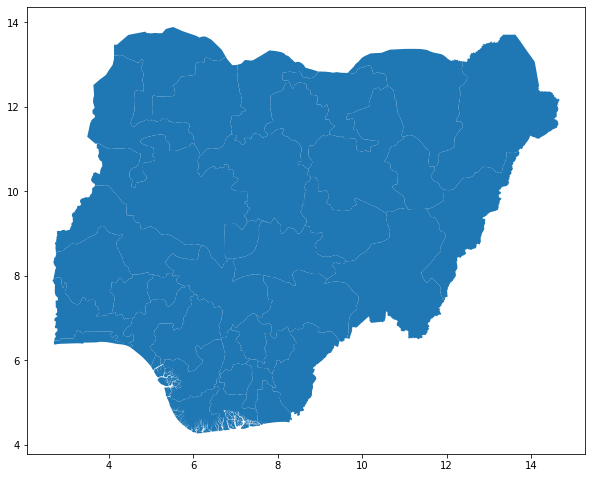

In [43]:
#gdf10 = pd.concat([gdf1['geometry'], gdf0['geometry']], axis=0)

#fig = plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1, figsize=(10, 10))
#ax = gdf0['geometry'].plot()
gdf['geometry'].plot(ax=ax)

plt.show()

In [44]:
geom = gdf[['NAME_1', 'geometry']]
geom = geom.rename(columns={"NAME_1": "State", "geometry": "geometry"})

geom = geom.set_index('State')
geom = geom.rename({'Federal Capital Territory': 'FCT Abuja', 'Akwa Ibom': 'Akwa Ibom', 'Nassarawa':'Nasarawa'})
geom

,geometry
State,
Abia,"POLYGON ((7.48998 4.85506, 7.49438 4.84743, 7...."
Adamawa,"POLYGON ((12.01237 7.50763, 12.00726 7.50804, ..."
Akwa Ibom,"MULTIPOLYGON (((7.55570 4.50408, 7.55597 4.504..."
Anambra,"POLYGON ((7.25012 5.92631, 7.24832 5.92668, 7...."
Bauchi,"POLYGON ((11.01984 9.70526, 11.02580 9.69224, ..."
Bayelsa,"MULTIPOLYGON (((5.43681 4.94736, 5.43681 4.947..."
Benue,"POLYGON ((7.82773 6.63027, 7.82988 6.64209, 7...."
Borno,"POLYGON ((11.94555 10.04476, 11.94380 10.04515..."
Cross River,"POLYGON ((8.47764 4.69097, 8.47764 4.69153, 8...."


In [45]:
print(dff.index)
print(geom.index)

Index(['Kaduna', 'Bauchi', 'Jigawa', 'Borno', 'Katsina', 'Kebbi', 'Yobe',
       'Edo', 'Ondo', 'Kano', 'Osun', 'Bayelsa', 'Zamfara', 'Nasarawa',
       'Sokoto', 'Lagos', 'Gombe', 'Kogi', 'Niger', 'Ogun', 'Benue', 'Plateau',
       'Delta', 'Akwa Ibom', 'Oyo', 'Rivers', 'FCT Abuja', 'Ekiti', 'Taraba',
       'Kwara', 'Enugu', 'Abia', 'Adamawa', 'Anambra', 'Cross River', 'Ebonyi',
       'Imo'],
      dtype='object', name='State')
Index(['Abia', 'Adamawa', 'Akwa Ibom', 'Anambra', 'Bauchi', 'Bayelsa', 'Benue',
       'Borno', 'Cross River', 'Delta', 'Ebonyi', 'Edo', 'Ekiti', 'Enugu',
       'FCT Abuja', 'Gombe', 'Imo', 'Jigawa', 'Kaduna', 'Kano', 'Katsina',
       'Kebbi', 'Kogi', 'Kwara', 'Lagos', 'Nasarawa', 'Niger', 'Ogun', 'Ondo',
       'Osun', 'Oyo', 'Plateau', 'Rivers', 'Sokoto', 'Taraba', 'Yobe',
       'Zamfara'],
      dtype='object', name='State')


In [46]:
dff = dff.join(geom)
dff.head()


,Enforcing Time (days),Enforcing Cost (% of claim value),Quality of judicial processes index (0–18),Procedures (Bussines start),Time (days - Bussines start),Bussines start Cost (% of income per capita),Procedures (Registering),Registering Time (days),Registering Cost (% of property value),Quality of land administration index (0–30),...,Quality control during construction (0–3)~0,Quality control during construction (0–3)~1,Quality control during construction (0–3)~2,Quality control after construction (0–3)~0,Quality control after construction (0–3)~1,Quality control after construction (0–3)~2,Liability and insurance regimes (0–2)~0,Kmean_class,Kmean_mini_class,geometry
State,,,,,,,,,,,,,,,,,,,,,
Kaduna,-1.437400,-1.256794,0.491539,-0.821924,-1.586979,0.083903,-1.451165,-0.706239,-1.047345,1.140282,...,0,1,0,0,1,0,1,2,0,"POLYGON ((8.57854 9.45880, 8.58423 9.44824, 8...."
Bauchi,-0.169487,-2.090229,0.491539,0.099627,0.545948,-0.773509,-0.108837,-0.989012,0.145318,-0.810721,...,0,1,0,0,1,0,1,0,0,"POLYGON ((11.01984 9.70526, 11.02580 9.69224, ..."
Jigawa,-1.831481,-0.337879,0.491539,-0.821924,-0.206850,0.645657,0.338605,-1.220372,-0.851826,0.408656,...,0,1,0,0,0,1,1,2,0,"POLYGON ((10.27572 11.08163, 10.25810 11.07815..."
Borno,-0.889114,-1.149943,0.491539,-0.821924,0.295015,0.083903,-0.108837,-0.423465,-0.363030,-0.322970,...,0,1,0,0,1,0,1,2,0,"POLYGON ((11.94555 10.04476, 11.94380 10.04515..."
Katsina,-0.854846,-1.171314,0.491539,-1.743474,-0.206850,0.083903,-0.556280,-1.014718,-0.441238,-1.054596,...,0,1,0,0,1,0,1,2,0,"POLYGON ((7.21687 11.12914, 7.20944 11.12443, ..."


<AxesSubplot:>

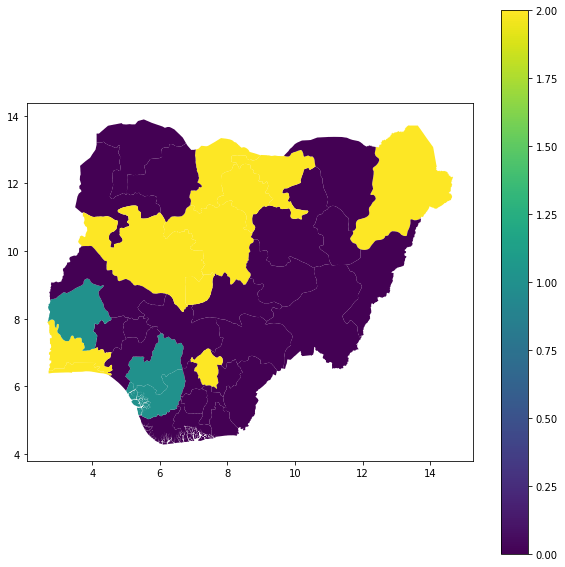

In [47]:
dff_class = dff[['Kmean_class', 'geometry']]
from geopandas import GeoDataFrame
dff_class = GeoDataFrame(dff_class)

dff_class.head()
fig, ax = plt.subplots(1, figsize=(10, 10))
dff_class.plot(column='Kmean_class', ax=ax, legend=True)

In [48]:
df_DTFScore_tmp = df_DTFScore.set_index('State')
df_DTFScore_tmp = df_DTFScore_tmp.join(dff_class)
df_DTFScore_tmp.head()

,"DTF score,\n2018\n(4 indicators)","Average\nDTF score,\n2014\n(4 indicators)",Starting a business (Score),Dealing with\nconstruction permits (Score),Registering property (Score),Enforcing contracts (Score),Kmean_class,geometry
State,,,,,,,,
Abia,53.90,48.24,77.10,72.72,17.67,48.11,0,"POLYGON ((7.48998 4.85506, 7.49438 4.84743, 7...."
Adamawa,54.34,52.83,71.96,73.63,23.93,47.84,0,"POLYGON ((12.01237 7.50763, 12.00726 7.50804, ..."
Akwa Ibom,55.66,53.41,76.17,71.31,21.46,53.70,0,"MULTIPOLYGON (((7.55570 4.50408, 7.55597 4.504..."
Anambra,53.50,48.60,76.69,70.18,19.33,47.80,0,"POLYGON ((7.25012 5.92631, 7.24832 5.92668, 7...."
Bauchi,60.60,56.85,76.06,74.10,28.26,63.99,0,"POLYGON ((11.01984 9.70526, 11.02580 9.69224, ..."


<AxesSubplot:>

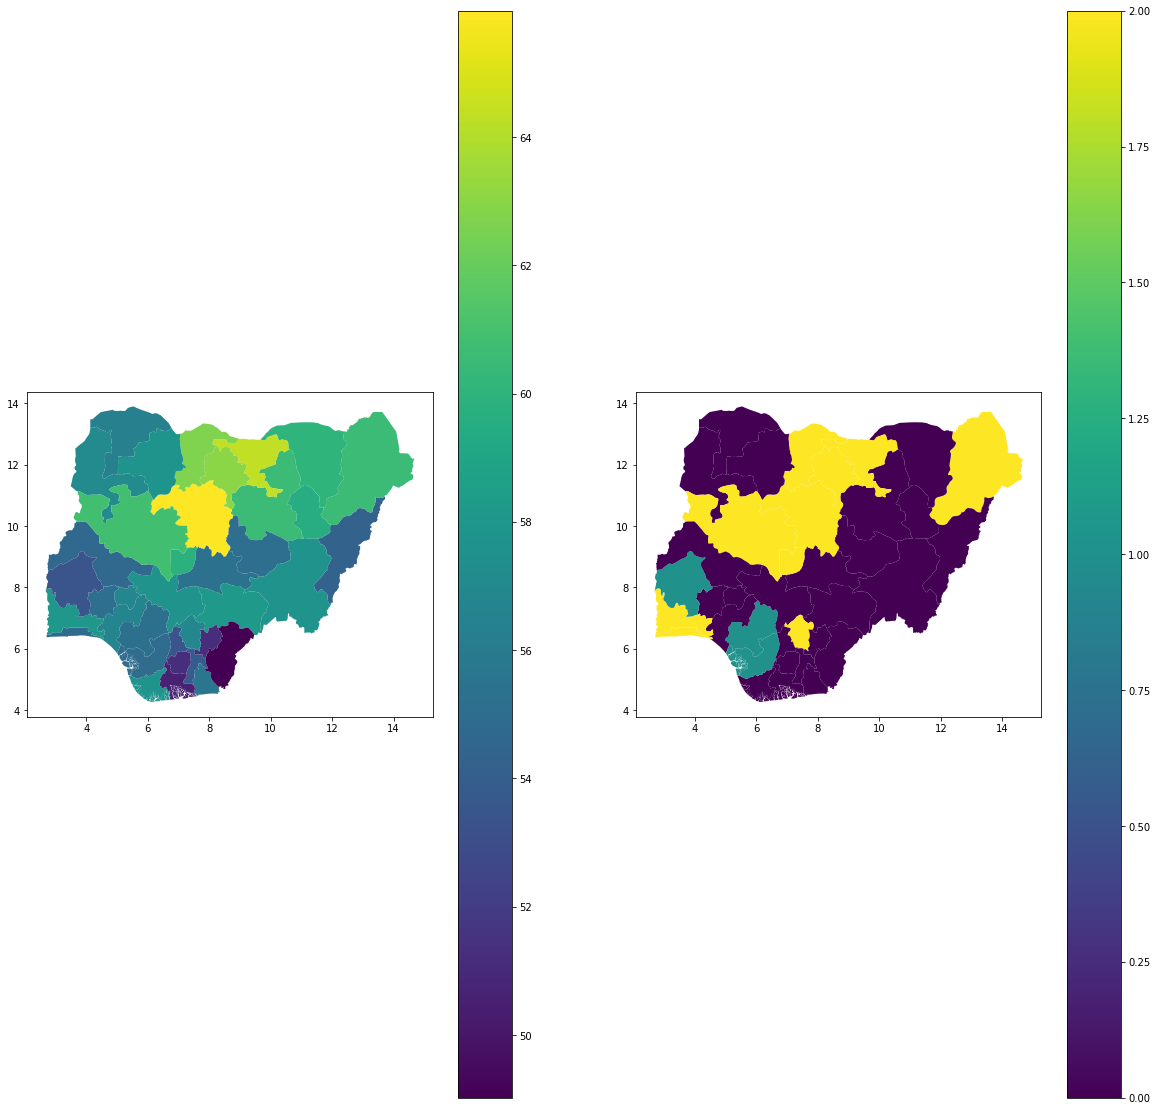

In [49]:
df_DTFScore_plot = df_DTFScore_tmp[['DTF score,\n2018\n(4 indicators)', 'geometry']]

df_DTFScore_plot = GeoDataFrame(df_DTFScore_plot)

df_DTFScore_plot.head()
fig, axs = plt.subplots(1,2, figsize=(20, 20))
df_DTFScore_plot.plot(column='DTF score,\n2018\n(4 indicators)', ax=axs[0], legend=True)
dff_class.plot(column='Kmean_class', ax=axs[1], legend=True)